# Analyse 3D Fish Track Probability Density Functions

In this example we reduce the complexity of the 3D PDF data by filtering
and converting to unsigned integer data. Then we plot a few timestesp of
the simplified dataset.

In [1]:
import xarray as xr
import s3fs

In [2]:
fsg = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
)

In [3]:
#import xarray as xr

store = s3fs.S3Map(
    root="s3://destine-gfts-data-lake/demo/A19124/three_d_pdf.zarr",
    s3=fsg,
    check=False,
)
data = xr.open_zarr(store=store, consolidated=True)
data

<xarray.Dataset> Size: 8GB
Dimensions:     (time: 258, y: 294, x: 659, depth: 20)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
  * depth       (depth) float64 160B 1.0 3.0 5.0 7.0 9.0 ... 33.0 35.0 37.0 39.0
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    3d_pdf      (time, y, x, depth) float64 8GB dask.array<chunksize=(48, 294, 659, 20), meta=np.ndarray>

In [4]:
# Threshold to remove near zero probabilities
small = data.where(data > 1e-6)
# Convert the pdf data to 16 bit integer
small["3d_pdf"] = (small["3d_pdf"] * 65535 // 2).astype("int16").compute()
# Remove metadata. These values can be reconstructed from simple min/max values
# in each variable, since the intervals are regular.
small = small.drop_vars(
    ["cell_ids", "depth", "latitude", "longitude", "resolution", "time"]
)
small.to_zarr("../data/A19124_3d_filtered.zarr", mode="w")
small

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


<xarray.Dataset> Size: 2GB
Dimensions:  (time: 258, y: 294, x: 659, depth: 20)
Dimensions without coordinates: time, y, x, depth
Data variables:
    3d_pdf   (time, y, x, depth) int16 2GB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [5]:
# Compress to about 600kb
!zip -rq ../data/A19124_3d_filtered.zarr.zip ../data/A19124_3d_filtered.zarr
!ls -lah ../data/A19124_3d_filtered.zarr.zip

-rw-r--r-- 1 jovyan users 622K Aug 22 19:08 ../data/A19124_3d_filtered.zarr.zip


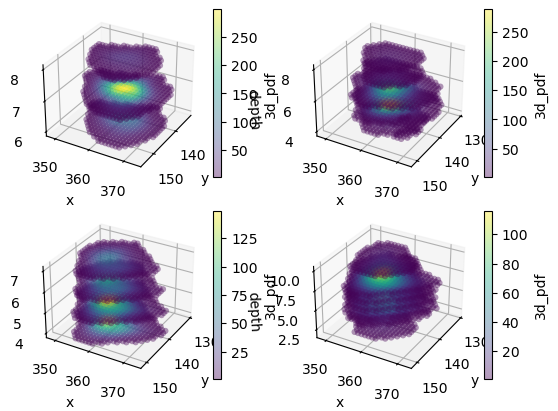

In [6]:
from matplotlib import pyplot as plt

# Plot a few time steps
small = xr.open_zarr("../data/A19124_3d_filtered.zarr")
for i, time in enumerate([55, 155, 180, 201]):
    plt.subplot(2, 2, i + 1, projection="3d")
    small_step = small.isel(time=time)
    threshold = 0
    small_step.where(small_step["3d_pdf"] > threshold).plot.scatter(
        x="x", z="y", y="depth", hue="3d_pdf", edgecolors="none", alpha=0.4
    )